In [1]:

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

# Set random seed for reproducibility [cite: 52]
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

# Path to dataset in Google Drive
data_path = '../data/Mall_Customers.csv'

# Load CSV
df = pd.read_csv(data_path)

# Preview data
print("Dataset shape:", df.shape)
df.info()

Dataset shape: (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [2]:
# 1. Preprocessing
# Encode Gender: Female=1, Male=0
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
X_raw = df.drop(columns=['CustomerID'])

# Standardize features (Crucial for K-means )
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

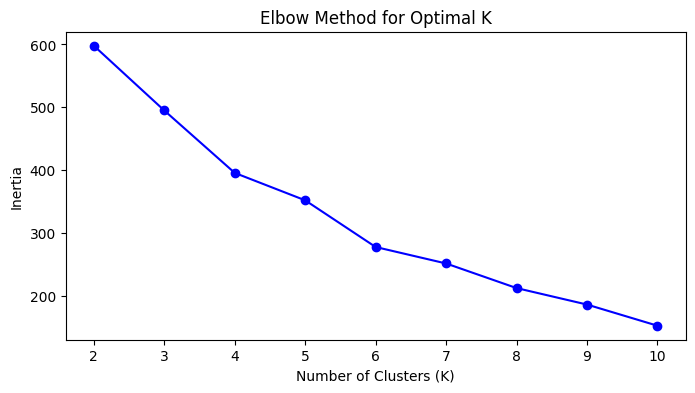

In [3]:
# 2. Elbow Method (Inertia)
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

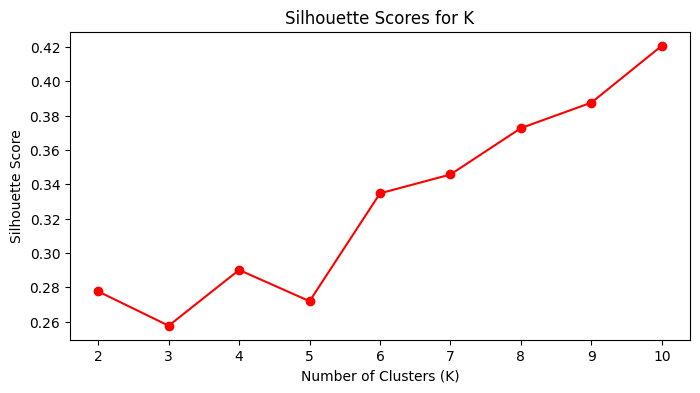


--- Cluster Mean Values ---
           Gender        Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                                 
0        0.490196  56.470588           46.098039               39.313725
1        0.000000  39.500000           85.150000               14.050000
2        0.000000  28.690476           60.904762               70.238095
3        1.000000  37.897959           82.122449               54.448980
4        1.000000  27.315789           38.842105               56.210526


In [4]:
# 3. Silhouette Score 
silhouette_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K_range, silhouette_scores, marker='o', color='r')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K')
plt.show()

# 4. Final Clustering (Choosing K=5 for better business interpretability)
k_final = 5
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\n--- Cluster Mean Values ---")
cluster_summary = df.groupby('Cluster').mean().drop(columns=['CustomerID'])
print(cluster_summary)

PCA Total Explained Variance: 59.92%


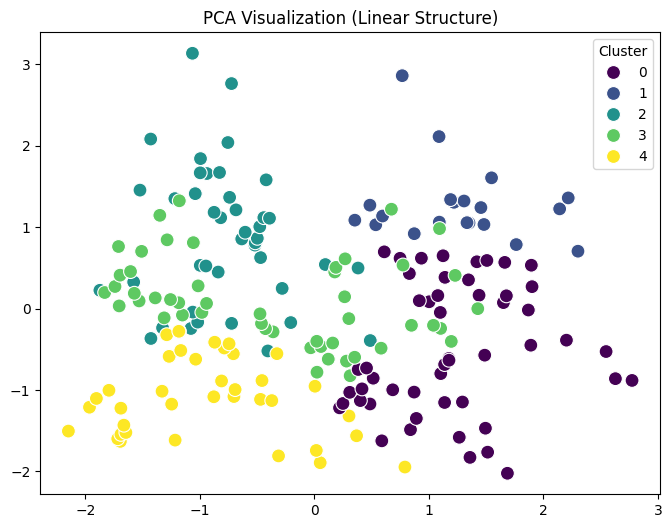

In [5]:
# 1. PCA Analysis
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA Total Explained Variance: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('PCA Visualization (Linear Structure)')
plt.show()


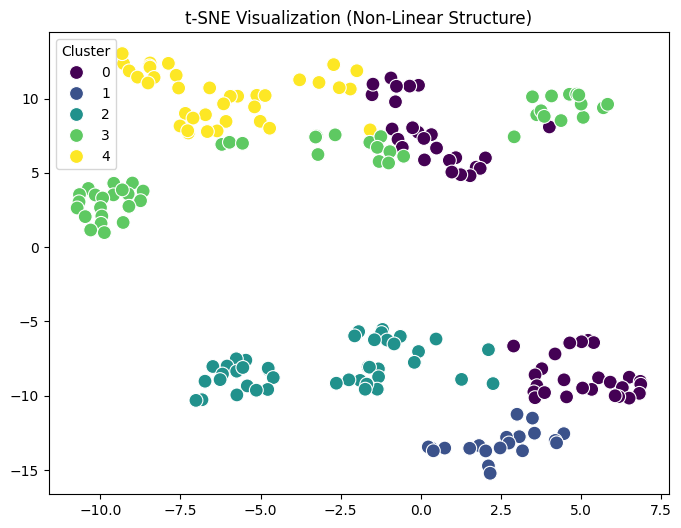

In [6]:

# 2. t-SNE Analysis
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['Cluster'], palette='viridis', s=100)
plt.title('t-SNE Visualization (Non-Linear Structure)')
plt.show()

In [7]:
# 1. Experiment with Contamination
contaminations = [0.01, 0.03, 0.05]
for c in contaminations:
    iso = IsolationForest(contamination=c, random_state=42)
    preds = iso.fit_predict(X_scaled)
    print(f"Contamination {c}: {(preds == -1).sum()} anomalies")



Contamination 0.01: 2 anomalies
Contamination 0.03: 6 anomalies
Contamination 0.05: 10 anomalies


In [8]:
# 2. Final Anomaly Detection
iso_final = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly'] = iso_final.fit_predict(X_scaled) # -1 = Anomaly, 1 = Normal



Total Anomalies detected: 10

Anomalies per Cluster:
Cluster
0    3
2    2
1    2
3    2
4    1
Name: count, dtype: int64


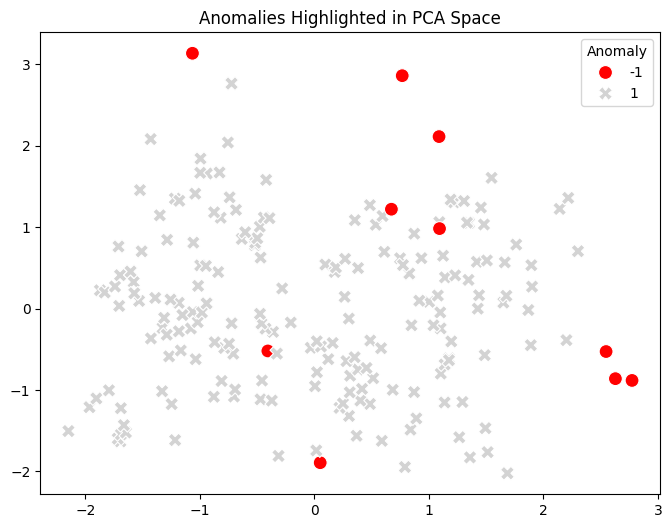

In [9]:

# 3. Analyze Anomalies
anomalies = df[df['Anomaly'] == -1]
print(f"\nTotal Anomalies detected: {len(anomalies)}")
print("\nAnomalies per Cluster:")
print(anomalies['Cluster'].value_counts())

# Visualize Anomalies on PCA Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Anomaly'], 
                palette={1: 'lightgrey', -1: 'red'}, style=df['Anomaly'], s=100)
plt.title('Anomalies Highlighted in PCA Space')
plt.show()

In [10]:
# Summary counts of segments and their unusual cases
summary_table = df.groupby(['Cluster', 'Anomaly']).size().unstack(fill_value=0)
summary_table.columns = ['Anomaly', 'Normal']
print("\n--- Integrated Cluster & Anomaly Summary ---")
print(summary_table)

# Final business characterization check
print("\nFinal Cluster Statistics (Mean):")
print(df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean())


--- Integrated Cluster & Anomaly Summary ---
         Anomaly  Normal
Cluster                 
0              3      48
1              2      18
2              2      40
3              2      47
4              1      37

Final Cluster Statistics (Mean):
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.470588           46.098039               39.313725
1        39.500000           85.150000               14.050000
2        28.690476           60.904762               70.238095
3        37.897959           82.122449               54.448980
4        27.315789           38.842105               56.210526
